In [1]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns',None)

In [2]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

/home/amit/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# df1 = pd.read_csv('../Data/adwords_keyword_account_position_20180418092434.csv',sep='|',nrows=10)

In [4]:
df = pd.read_csv('../Data/ADWORDS_KEYWORDS_PROCESSED.csv',
                 usecols=['_date', 'account', 'keyword', 'device_type', 'sessions', 'cost', 'cpc', 'reatrr_bookings','conversion', 'reattr_margin', 'roi', 'reattr_net', 'averageposition', 'impressions', 
                'max_cpc','search_impression_share'])

In [5]:
df.shape

(10036364, 16)

In [6]:
df['_date'] = pd.to_datetime(df['_date'])
print(df.shape)

backup = df.copy()

(10036364, 16)


In [7]:
df = df[df['account'] == 'Generic']
del df['account']

In [8]:
df.head()

,_date,keyword,device_type,sessions,cost,cpc,reatrr_bookings,conversion,reattr_margin,roi,reattr_net,averageposition,impressions,max_cpc,search_impression_share
352,2017-09-21,december 2018 holidays,Desktop,2.0,0.55,0.275,0.0,0.0,0.0,0.0,-0.55,2.0,5.0,0.51,100.0
353,2017-09-21,holidays for easter 2018,Desktop,1.0,0.30,0.300,0.0,0.0,0.0,0.0,-0.30,4.0,1.0,0.59,100.0
354,2017-09-21,may half term 2018 holidays,Desktop,1.0,0.39,0.390,0.0,0.0,0.0,0.0,-0.39,2.5,2.0,0.38,100.0
355,2017-09-21,holidays in january 2018,Desktop,2.0,1.51,0.755,0.0,0.0,0.0,0.0,-1.51,3.3,10.0,0.84,100.0
356,2017-09-21,june 2018 holidays,Desktop,1.0,0.43,0.430,0.0,0.0,0.0,0.0,-0.43,2.5,2.0,0.48,100.0


In [9]:
df.shape

(1539228, 15)

In [10]:
print (df['_date'].min())
print (df['_date'].max())

2016-01-01 00:00:00
2018-04-16 00:00:00


In [11]:
dctRenameCols = {
    '_date':'Date',
    'cpc':'AvgCPC',
    'averageposition': 'AvgPosition',
    'device_type': 'Device',
    'search_impression_share':'Impression Share',
    'max_cpc':'MaxCPC',
    'reatrr_bookings': 'Bookings',
    'reattr_net':'NetMargin',
    'reattr_margin':'Margin',
    'impressions':'Impressions',
    'sessions':'Sessions',
    'conversion':'Conversion'
}
df.rename(columns=dctRenameCols,inplace=True)
df.head()

,Date,keyword,Device,Sessions,cost,AvgCPC,Bookings,Conversion,Margin,roi,NetMargin,AvgPosition,Impressions,MaxCPC,Impression Share
352,2017-09-21,december 2018 holidays,Desktop,2.0,0.55,0.275,0.0,0.0,0.0,0.0,-0.55,2.0,5.0,0.51,100.0
353,2017-09-21,holidays for easter 2018,Desktop,1.0,0.30,0.300,0.0,0.0,0.0,0.0,-0.30,4.0,1.0,0.59,100.0
354,2017-09-21,may half term 2018 holidays,Desktop,1.0,0.39,0.390,0.0,0.0,0.0,0.0,-0.39,2.5,2.0,0.38,100.0
355,2017-09-21,holidays in january 2018,Desktop,2.0,1.51,0.755,0.0,0.0,0.0,0.0,-1.51,3.3,10.0,0.84,100.0
356,2017-09-21,june 2018 holidays,Desktop,1.0,0.43,0.430,0.0,0.0,0.0,0.0,-0.43,2.5,2.0,0.48,100.0


In [12]:
df.dtypes

Date                datetime64[ns]
keyword                     object
Device                      object
Sessions                   float64
cost                       float64
AvgCPC                     float64
Bookings                   float64
Conversion                 float64
Margin                     float64
roi                        float64
NetMargin                  float64
AvgPosition                float64
Impressions                float64
MaxCPC                     float64
Impression Share           float64
dtype: object

In [13]:
# Checking Correlations
df.corr().round(2)

# Cost and Sessions highly correlated r = .89
# Margin & Bookings approaching multicolinearity colinear r = .92

,Sessions,cost,AvgCPC,Bookings,Conversion,Margin,roi,NetMargin,AvgPosition,Impressions,MaxCPC,Impression Share
Sessions,1.00,0.89,0.05,0.60,0.00,0.52,-0.00,-0.14,0.02,0.74,0.09,-0.01
cost,0.89,1.00,0.14,0.62,0.01,0.56,-0.00,-0.19,0.00,0.70,0.14,0.01
AvgCPC,0.05,0.14,1.00,0.07,0.04,0.07,-0.01,-0.04,-0.15,0.07,0.49,0.16
Bookings,0.60,0.62,0.07,1.00,0.39,0.92,0.24,0.56,0.02,0.48,0.09,-0.01
Conversion,0.00,0.01,0.04,0.39,1.00,0.36,0.63,0.42,-0.00,0.00,0.03,0.00
Margin,0.52,0.56,0.07,0.92,0.36,1.00,0.29,0.71,0.02,0.43,0.09,-0.00
roi,-0.00,-0.00,-0.01,0.24,0.63,0.29,1.00,0.34,0.01,0.00,-0.00,-0.01
NetMargin,-0.14,-0.19,-0.04,0.56,0.42,0.71,0.34,1.00,0.02,-0.09,-0.01,-0.01
AvgPosition,0.02,0.00,-0.15,0.02,-0.00,0.02,0.01,0.02,1.00,0.07,-0.27,-0.47
Impressions,0.74,0.70,0.07,0.48,0.00,0.43,0.00,-0.09,0.07,1.00,0.06,-0.06


In [14]:
# # CREATE DUMMIES
# # Month
print ('Before Dummies',df.shape)
df = df.merge(pd.get_dummies(df['Date'].dt.strftime('%B')),left_index=True,right_index=True,how='left')
print ('After Month',df.shape)


Before Dummies (1539228, 15)
After Month (1539228, 27)


In [15]:
# Weekday
df = df.merge(pd.get_dummies(df['Date'].dt.strftime('%A')),left_index=True,right_index=True,how='left')
print ('After Weekday',df.shape)


After Weekday (1539228, 34)


In [16]:
# creating dummy variables for DEVICES

df = df.merge(pd.get_dummies(df['Device']),left_index=True,right_index=True,how='left')
print ('Device',df.shape)

Device (1539228, 37)


In [17]:
display(df['Device'].value_counts())
display(df.head())
print(df.columns)

Mobile Phone    611850
Desktop         547973
Tablet          379405
Name: Device, dtype: int64

,Date,keyword,Device,Sessions,cost,AvgCPC,Bookings,Conversion,Margin,roi,NetMargin,AvgPosition,Impressions,MaxCPC,Impression Share,April,August,December,February,January,July,June,March,May,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Desktop,Mobile Phone,Tablet
352,2017-09-21,december 2018 holidays,Desktop,2.0,0.55,0.275,0.0,0.0,0.0,0.0,-0.55,2.0,5.0,0.51,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
353,2017-09-21,holidays for easter 2018,Desktop,1.0,0.30,0.300,0.0,0.0,0.0,0.0,-0.30,4.0,1.0,0.59,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
354,2017-09-21,may half term 2018 holidays,Desktop,1.0,0.39,0.390,0.0,0.0,0.0,0.0,-0.39,2.5,2.0,0.38,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
355,2017-09-21,holidays in january 2018,Desktop,2.0,1.51,0.755,0.0,0.0,0.0,0.0,-1.51,3.3,10.0,0.84,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
356,2017-09-21,june 2018 holidays,Desktop,1.0,0.43,0.430,0.0,0.0,0.0,0.0,-0.43,2.5,2.0,0.48,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0


Index(['Date', 'keyword', 'Device', 'Sessions', 'cost', 'AvgCPC', 'Bookings',
       'Conversion', 'Margin', 'roi', 'NetMargin', 'AvgPosition',
       'Impressions', 'MaxCPC', 'Impression Share', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Desktop', 'Mobile Phone',
       'Tablet'],
      dtype='object')


In [18]:
dctRenameCols = {
    'Mobile Phone':'Mobile'}
df.rename(columns=dctRenameCols,inplace=True) 
df.head()

,Date,keyword,Device,Sessions,cost,AvgCPC,Bookings,Conversion,Margin,roi,NetMargin,AvgPosition,Impressions,MaxCPC,Impression Share,April,August,December,February,January,July,June,March,May,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Desktop,Mobile,Tablet
352,2017-09-21,december 2018 holidays,Desktop,2.0,0.55,0.275,0.0,0.0,0.0,0.0,-0.55,2.0,5.0,0.51,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
353,2017-09-21,holidays for easter 2018,Desktop,1.0,0.30,0.300,0.0,0.0,0.0,0.0,-0.30,4.0,1.0,0.59,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
354,2017-09-21,may half term 2018 holidays,Desktop,1.0,0.39,0.390,0.0,0.0,0.0,0.0,-0.39,2.5,2.0,0.38,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
355,2017-09-21,holidays in january 2018,Desktop,2.0,1.51,0.755,0.0,0.0,0.0,0.0,-1.51,3.3,10.0,0.84,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
356,2017-09-21,june 2018 holidays,Desktop,1.0,0.43,0.430,0.0,0.0,0.0,0.0,-0.43,2.5,2.0,0.48,100.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0


In [19]:
df.to_csv('../Data/GenericAccDF.csv', index = False)

In [20]:
df.groupby(['keyword'])['Sessions'].sum().nlargest(20)

keyword
cheap holidays                  544741.0
holidays                        541069.0
all inclusive holidays          354916.0
holiday                         250683.0
holidays 2018                   156396.0
holidays 2017                   139351.0
+holidays                       130397.0
cheap all inclusive holidays    105937.0
cheap holidays 2018              82064.0
all inclusive                    73770.0
+holiday                         63700.0
weekend breaks                   50248.0
holiday deals                    49742.0
all inclusive holidays 2018      47908.0
package holidays                 43736.0
cheap holidays 2017              40597.0
+cheap +holidays                 40425.0
free child places                40249.0
all inclusive holidays 2017      39974.0
cheap holiday                    39357.0
Name: Sessions, dtype: float64

In [21]:
df.groupby(['keyword'])['Conversion'].sum().nlargest(20)

keyword
low deposit holidays            57.873281
holidays                        39.710335
cheap all inclusive holidays    35.053740
all inclusive holidays          34.706040
beach holidays                  33.506501
pay monthly holidays            33.200827
deposit holidays                32.762605
low deposit holiday             32.452710
cheap holidays                  28.469614
holiday                         25.399671
cheap holiday                   24.381921
cheap all inclusive             23.283568
compare holidays                23.267302
holidays 2017                   23.247204
+low +deposit +holidays         21.746439
all inclusive holiday           21.084414
holiday comparison              21.025949
cheap holidays all inclusive    20.198706
cheap beach holidays            19.964687
half board holidays             19.944996
Name: Conversion, dtype: float64

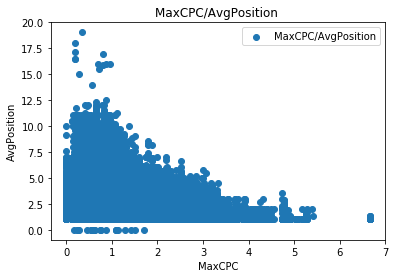

In [22]:
# Scatterplots MaxCPC vs AvgPosition 

x = df['MaxCPC']
y = df['AvgPosition']

plt.scatter(x, y, label='MaxCPC/AvgPosition')
plt.xlabel('MaxCPC')
plt.ylabel('AvgPosition')
plt.title('MaxCPC/AvgPosition ')
plt.legend()
plt.show()


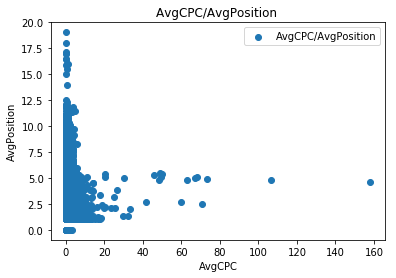

In [23]:
# Scatterplots MaxCPC vs AvgPosition 

x = df['AvgCPC']
y = df['AvgPosition']

plt.scatter(x, y, label='AvgCPC/AvgPosition')
plt.xlabel('AvgCPC')
plt.ylabel('AvgPosition')
plt.title('AvgCPC/AvgPosition ')
plt.legend()
plt.show()


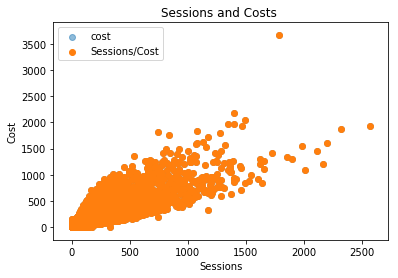

In [24]:
# Scatterplots

x = df['Sessions']
y = df['cost']

plt.scatter(x, y, alpha=0.5)

plt.scatter(x, y, label='Sessions/Cost')
plt.xlabel('Sessions')
plt.ylabel('Cost')
plt.title('Sessions and Costs ')
plt.legend()
plt.show()


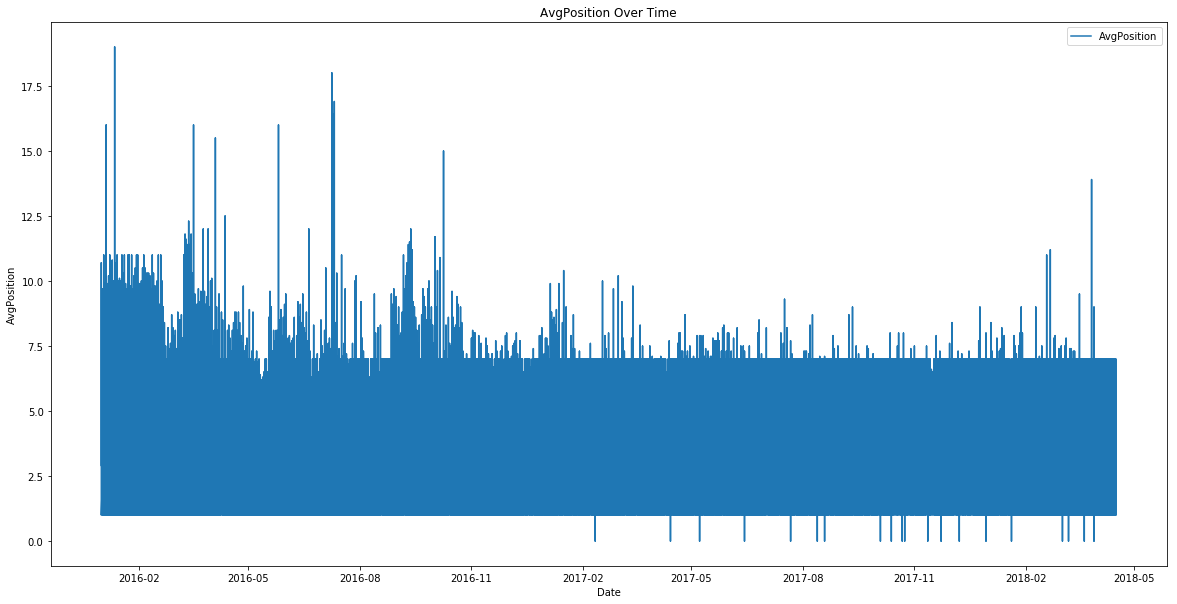

In [25]:
#AvgPosition overtime 

X = df['Date']
y = df['AvgPosition']

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))

plt.plot(X, y, label='AvgPosition')
plt.xlabel('Date')
plt.ylabel('AvgPosition')
plt.title('AvgPosition Over Time')
plt.legend()
plt.show()

In [28]:
# OLS model for AVGPosition as a function of avgcpc, sessions, impressions, impression share,  max cpc + 
# Dummy variables for Devices, Months and Day of the week.

position_model = ols("""AvgPosition ~ AvgCPC + Sessions + Impressions  + MaxCPC + Desktop + Mobile + Tablet + Friday + Monday + Saturday + 
    Sunday + April + August + December + February + January + July + June + March + May + November + October + September""", data=df).fit()
print ('Done OLS!')
# summarize our model
position_model_summary = position_model.summary()
position_model_summary

# R2 without Weekday and Month dummies = 0.087
# R2 WITH Weekday and Month dummies = 0.117


Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            AvgPosition   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     9750.
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        15:58:23   Log-Likelihood:            -2.4583e+06
No. Observations:             1539228   AIC:                         4.917e+06
Df Residuals:                 1539206   BIC:                         4.917e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.6119      0.002   1493.803      0.000       2.608       2.615
AvgCPC         -0.0628      0.002    -29.838      0.000      -0.067      -0.059
Sessions       -0.0033   5.93e-05    -55.941      0.000      -0.003      -0.003
Impressions     0.0004   3.16e-06    117.923      0.000       0.000       0.000
MaxCPC         -0.8772      0.003   -312.779      0.000      -0.883      -0.872
Desktop         0.7675      0.002    501.967      0.000       0.764       0.770
Mobile          0.9475      0.002    625.049      0.000       0.944       0.950
Tablet          0.8970      0.002    537.067      0.000       0.894       0.900
Friday          0.0065      0.003      2.110      0.035       0.000       0.013
Monday          0.0540      0.003     18.410      0.000       0.048       0.060
Saturday       -0.1078      0.003    -36.410      0.000      -0.114      -0.102
Sunday         -0.0575      0.003    -20.618      0.000      -0.063      -0.052
April           0.2655      0.003     87.618      0.000       0.260       0.271
August          0.0285      0.003      8.713      0.000       0.022       0.035
December        0.1196      0.004     30.295      0.000       0.112       0.127
February        0.5690      0.003    179.708      0.000       0.563       0.575
January         0.6571      0.003    221.672      0.000       0.651       0.663
July            0.0426      0.003     13.703      0.000       0.036       0.049
June            0.1442      0.003     44.376      0.000       0.138       0.151
March           0.3931      0.003    133.234      0.000       0.387       0.399
May             0.2504      0.003     78.304      0.000       0.244       0.257
November       -0.0013      0.004     -0.363      0.717      -0.008       0.006
October        -0.0328      0.003    -10.329      0.000      -0.039      -0.027
September       0.1760      0.003     53.308      0.000       0.170       0.182
==============================================================================
Omnibus:                    38544.271   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43630.517
Skew:                           0.360   Prob(JB):                         0.00
Kurtosis:                       3.403   Cond. No.                     7.38e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.98e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
df['Pred_position'] = position_model.predict()

In [34]:
# OLS model for Sessions as a function of avgcpc, predicted position, impressions, impression share,  max cpc + 
# Dummy variables for Devices, Months and Day of the week.


sessions_model = ols("""Sessions ~ Pred_position + AvgCPC + MaxCPC + + Impressions +  Desktop + Mobile + Tablet + Friday + Monday + Saturday + 
    Sunday + April + August + December + January + July + June +October + September""", data=df).fit()
print ('Done OLS!')
# summarize our model
sessions_model_summary = sessions_model.summary()
sessions_model_summary

# R2 without Weekday and Month dummies = 0.577
# R2 WITH Weekday and Month dummies = 0.635

Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Sessions   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                 1.490e+05
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:00:08   Log-Likelihood:            -6.3186e+06
No. Observations:             1539228   AIC:                         1.264e+07
Df Residuals:                 1539209   BIC:                         1.264e+07
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       159.3718      0.271    587.512      0.000     158.840     159.903
Pred_position   -55.9517      0.095   -590.625      0.000     -56.137     -55.766
AvgCPC           -2.8337      0.026   -108.597      0.000      -2.885      -2.783
MaxCPC          -47.2161      0.091   -518.851      0.000     -47.394     -47.038
Impressions       0.0530   3.48e-05   1522.917      0.000       0.053       0.053
Desktop          46.5702      0.082    565.613      0.000      46.409      46.732
Mobile           58.8095      0.099    594.471      0.000      58.616      59.003
Tablet           53.9921      0.095    566.505      0.000      53.805      54.179
Friday            0.5176      0.038     13.599      0.000       0.443       0.592
Monday            3.1639      0.036     86.913      0.000       3.093       3.235
Saturday         -5.6624      0.038   -150.333      0.000      -5.736      -5.589
Sunday           -2.7506      0.035    -79.327      0.000      -2.819      -2.683
April            -3.3354      0.044    -75.851      0.000      -3.422      -3.249
August          -16.4845      0.055   -300.299      0.000     -16.592     -16.377
December        -11.4888      0.059   -196.022      0.000     -11.604     -11.374
January          18.9508      0.052    361.477      0.000      18.848      19.054
July            -15.6443      0.052   -298.372      0.000     -15.747     -15.542
June            -10.1850      0.050   -204.888      0.000     -10.282     -10.088
October         -19.9463      0.057   -351.076      0.000     -20.058     -19.835
September        -8.2839      0.049   -167.835      0.000      -8.381      -8.187
==============================================================================
Omnibus:                  1996327.383   Durbin-Watson:                   1.574
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      62394907925.041
Skew:                           5.644   Prob(JB):                         0.00
Kurtosis:                     989.280   Cond. No.                     1.51e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.43e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [35]:
df['Pred_sessions'] = sessions_model.predict()

In [36]:
# OLS reg for Net Attributed Margin as a function of the predicted values for Position and Sessions

cpc_model = ols("""NetMargin ~ Pred_position + Pred_sessions""", data=df).fit()
print ('Done OLS!')
# summarize our model
cpc_model_summary = cpc_model.summary()
cpc_model_summary

# R2 = 0.011

Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NetMargin   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     8299.
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:00:29   Log-Likelihood:            -7.3701e+06
No. Observations:             1539228   AIC:                         1.474e+07
Df Residuals:                 1539225   BIC:                         1.474e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.6161      0.161     -3.823      0.000      -0.932      -0.300
Pred_position     0.5285      0.054      9.818      0.000       0.423       0.634
Pred_sessions    -0.1560      0.001   -128.813      0.000      -0.158      -0.154
==============================================================================
Omnibus:                  2613543.755   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      13390116314.839
Skew:                          11.024   Prob(JB):                         0.00
Kurtosis:                     459.394   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# OLS reg for MaxCPC as a function of the predicted values for Position and Sessions

cpc_model = ols("""MaxCPC ~ Pred_position + Pred_sessions""", data=df).fit()
print ('Done OLS!')
# summarize our model
cpc_model_summary = cpc_model.summary()
cpc_model_summary

# R2 = 0.648

Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MaxCPC   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 1.414e+06
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:00:39   Log-Likelihood:                -25268.
No. Observations:             1539228   AIC:                         5.054e+04
Df Residuals:                 1539225   BIC:                         5.058e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.0361      0.001   2225.088      0.000       3.033       3.039
Pred_position    -0.7591      0.000  -1665.965      0.000      -0.760      -0.758
Pred_sessions     0.0033   1.03e-05    325.069      0.000       0.003       0.003
==============================================================================
Omnibus:                   405500.725   Durbin-Watson:                   0.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4266643.197
Skew:                           0.967   Prob(JB):                         0.00
Kurtosis:                      10.924   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
### OLS separately for each Device 

In [39]:
Deskdf = df[df['Device']=='Desktop']


In [40]:
Deskdf.shape

(547973, 39)

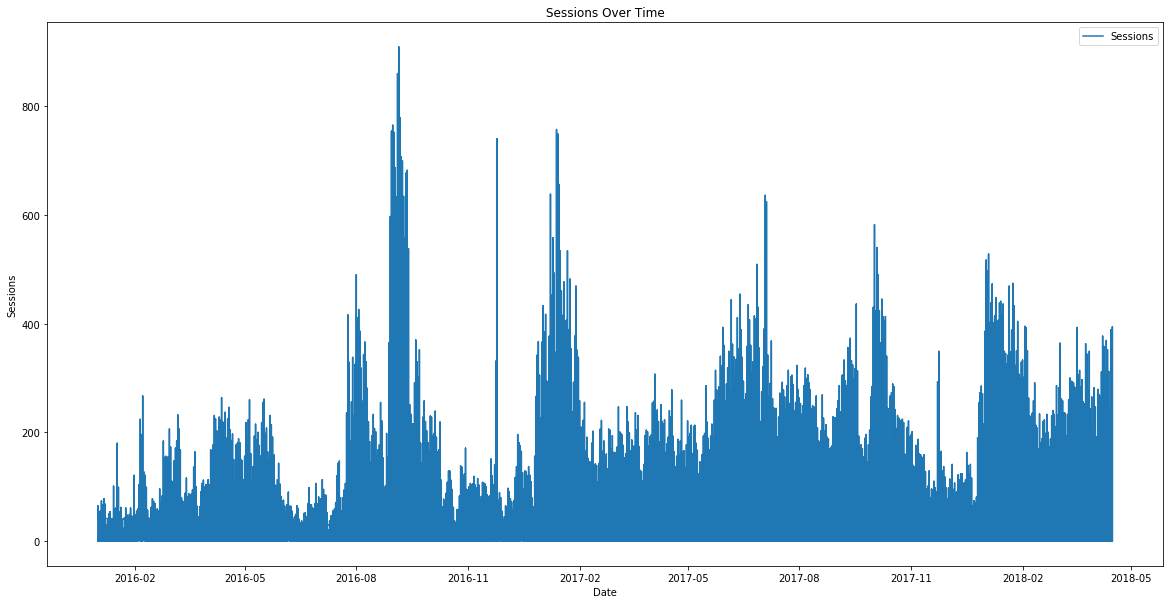

In [41]:
# Clicks Overtime

X = Deskdf['Date']
y = Deskdf['Sessions']

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))

plt.plot(X, y, label='Sessions')
plt.xlabel('Date')
plt.ylabel('Sessions')
plt.title('Sessions Over Time')
plt.legend()
plt.show()


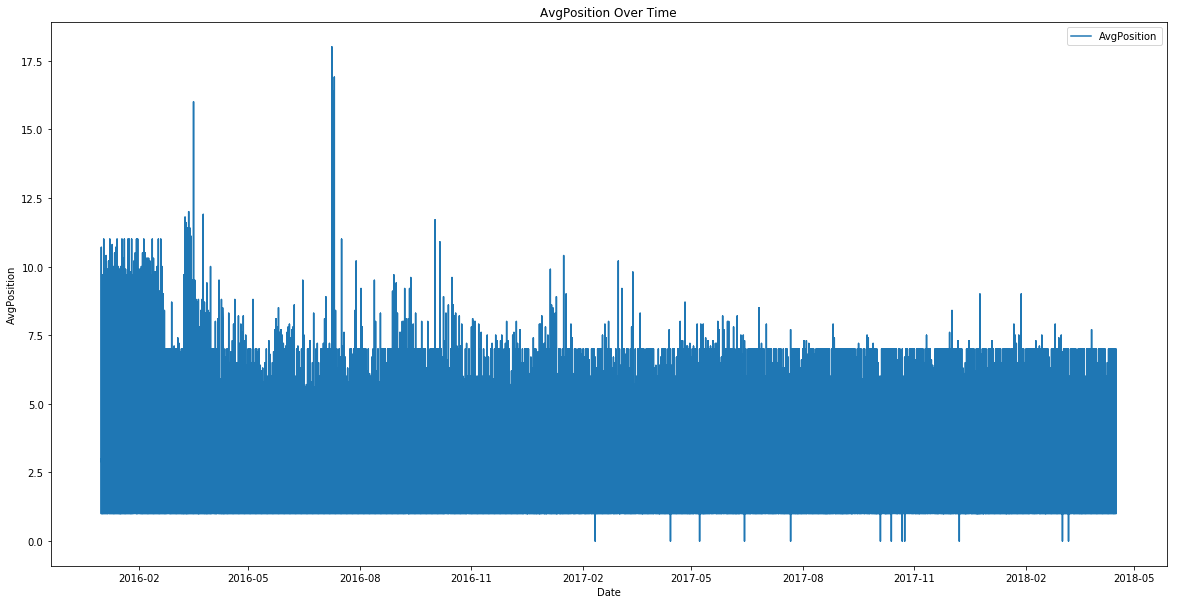

In [42]:
#AvgPosition overtime 

X = Deskdf['Date']
y = Deskdf['AvgPosition']

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))

plt.plot(X, y, label='AvgPosition')
plt.xlabel('Date')
plt.ylabel('AvgPosition')
plt.title('AvgPosition Over Time')
plt.legend()
plt.show()

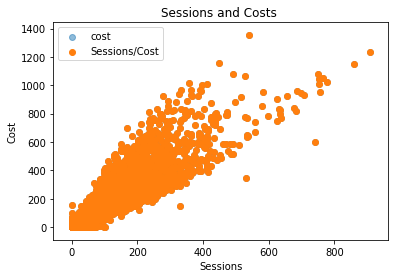

In [43]:
# Scatterplots

x = Deskdf['Sessions']
y = Deskdf['cost']

plt.scatter(x, y, alpha=0.5)

plt.scatter(x, y, label='Sessions/Cost')
plt.xlabel('Sessions')
plt.ylabel('Cost')
plt.title('Sessions and Costs ')
plt.legend()
plt.show()

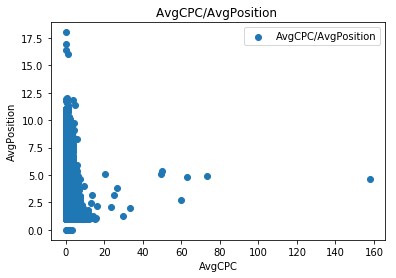

In [44]:
# Scatterplots MaxCPC vs AvgPosition 

x = Deskdf['AvgCPC']
y = Deskdf['AvgPosition']

plt.scatter(x, y, label='AvgCPC/AvgPosition')
plt.xlabel('AvgCPC')
plt.ylabel('AvgPosition')
plt.title('AvgCPC/AvgPosition ')
plt.legend()
plt.show()


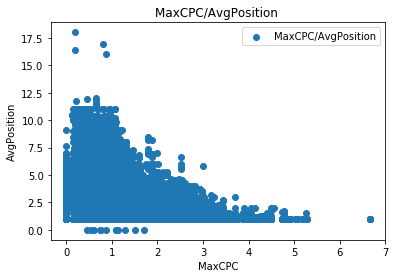

In [45]:
# Scatterplots MaxCPC vs AvgPosition 

x = Deskdf['MaxCPC']
y = Deskdf['AvgPosition']

plt.scatter(x, y, label='MaxCPC/AvgPosition')
plt.xlabel('MaxCPC')
plt.ylabel('AvgPosition')
plt.title('MaxCPC/AvgPosition ')
plt.legend()
plt.show()

In [46]:
Deskdf.columns

Index(['Date', 'keyword', 'Device', 'Sessions', 'cost', 'AvgCPC', 'Bookings',
       'Conversion', 'Margin', 'roi', 'NetMargin', 'AvgPosition',
       'Impressions', 'MaxCPC', 'Impression Share', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Desktop', 'Mobile',
       'Tablet', 'Pred_position', 'Pred_sessions'],
      dtype='object')

In [47]:
# OLS model for AVGPosition as a function of avgcpc, sessions, impressions, impression share,  max cpc + 
# Dummy variables for Devices, Months and Day of the week.

position_model = ols("""AvgPosition ~ AvgCPC + Sessions + Impressions + MaxCPC + Bookings + Conversion""", data=df).fit()
print ('Done OLS!')
# summarize our model
position_model_summary = position_model.summary()
position_model_summary

# R2 = 0.084


Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            AvgPosition   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                 2.353e+04
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:01:51   Log-Likelihood:            -2.4869e+06
No. Observations:             1539228   AIC:                         4.974e+06
Df Residuals:                 1539221   BIC:                         4.974e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.6445      0.002   1692.731      0.000       3.640       3.649
AvgCPC         -0.0828      0.002    -43.025      0.000      -0.087      -0.079
Sessions       -0.0039   6.78e-05    -57.947      0.000      -0.004      -0.004
Impressions     0.0004   3.23e-06    113.225      0.000       0.000       0.000
MaxCPC         -0.7880      0.003   -289.831      0.000      -0.793      -0.783
Bookings        0.2193      0.008     27.621      0.000       0.204       0.235
Conversion     -0.0805      0.024     -3.368      0.001      -0.127      -0.034
==============================================================================
Omnibus:                    43587.204   Durbin-Watson:                   1.391
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49205.882
Skew:                           0.391   Prob(JB):                         0.00
Kurtosis:                       3.394   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
df['Pred_position'] = position_model.predict()

In [49]:
# OLS regression for Sessions as a function of the predicted position from the ols above, AvgCPC, Mobile, 
# and the months March, aug, and oct based on the time series graph above.

sessions_model = ols("""Sessions ~ Pred_position + AvgCPC + MaxCPC+ Bookings + Conversion + AvgPosition""", data=df).fit()
print ('Done OLS!')
# summarize our model
sessions_model_summary = sessions_model.summary()
sessions_model_summary

# R2 without Weekday and Month dummies = 0.435


Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Sessions   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                 1.973e+05
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:03:03   Log-Likelihood:            -6.6561e+06
No. Observations:             1539228   AIC:                         1.331e+07
Df Residuals:                 1539221   BIC:                         1.331e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -79.6595      0.480   -166.047      0.000     -80.600     -78.719
Pred_position    22.2687      0.132    168.843      0.000      22.010      22.527
AvgCPC            1.4158      0.030     46.782      0.000       1.357       1.475
MaxCPC           19.5928      0.112    174.470      0.000      19.373      19.813
Bookings         88.1099      0.103    857.493      0.000      87.909      88.311
Conversion     -133.4781      0.343   -389.589      0.000    -134.150    -132.807
AvgPosition    5.696e-13      0.012   4.71e-11      1.000      -0.024       0.024
==============================================================================
Omnibus:                  3503489.266   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      73541002103.123
Skew:                          21.474   Prob(JB):                         0.00
Kurtosis:                    1072.964   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
df['Pred_sessions'] = sessions_model.predict()

In [51]:
# OLS reg for NetMargin as a function of the predicted values created above

cpc_model = ols("""NetMargin ~ Pred_position + Pred_sessions""", data=df).fit()
print ('Done OLS!')
# summarize our model
cpc_model_summary = cpc_model.summary()
cpc_model_summary

# R2 = 0.161

Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NetMargin   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                 1.482e+05
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:03:31   Log-Likelihood:            -7.2428e+06
No. Observations:             1539228   AIC:                         1.449e+07
Df Residuals:                 1539225   BIC:                         1.449e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -10.6045      0.175    -60.584      0.000     -10.948     -10.261
Pred_position     2.5455      0.059     43.378      0.000       2.430       2.661
Pred_sessions     0.7252      0.001    537.154      0.000       0.723       0.728
==============================================================================
Omnibus:                   851773.784   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      17550844731.212
Skew:                           0.631   Prob(JB):                         0.00
Kurtosis:                     526.121   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# OLS reg for MaxCPC as a function of the predicted values created above

cpc_model = ols("""MaxCPC ~ Pred_position + Pred_sessions""", data=df).fit()
print ('Done OLS!')
# summarize our model
cpc_model_summary = cpc_model.summary()
cpc_model_summary

R2 = 0.915


Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MaxCPC   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 8.324e+06
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:03:47   Log-Likelihood:             1.0727e+06
No. Observations:             1539228   AIC:                        -2.145e+06
Df Residuals:                 1539225   BIC:                        -2.145e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.9443      0.001   5001.207      0.000       3.943       3.946
Pred_position    -1.0685      0.000  -4041.067      0.000      -1.069      -1.068
Pred_sessions     0.0055   6.08e-06    897.788      0.000       0.005       0.005
==============================================================================
Omnibus:                  3561844.926   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     219641541357.266
Skew:                          21.876   Prob(JB):                         0.00
Kurtosis:                    1853.078   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# OLS regression for Max CPC 

MaxCPC_model = ols("""MaxCPC ~ Sessions + cost + AvgCPC + MaxCPC + Bookings + Conversion + roi + NetMargin + Impressions""", data=df).fit()
print ('Done OLS!')
# summarize our model
sessions_model_summary = sessions_model.summary()
sessions_model_summary

# R2  = 0.163


Done OLS!


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Sessions   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                 1.973e+05
Date:                Fri, 20 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:04:13   Log-Likelihood:            -6.6561e+06
No. Observations:             1539228   AIC:                         1.331e+07
Df Residuals:                 1539221   BIC:                         1.331e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -79.6595      0.480   -166.047      0.000     -80.600     -78.719
Pred_position    22.2687      0.132    168.843      0.000      22.010      22.527
AvgCPC            1.4158      0.030     46.782      0.000       1.357       1.475
MaxCPC           19.5928      0.112    174.470      0.000      19.373      19.813
Bookings         88.1099      0.103    857.493      0.000      87.909      88.311
Conversion     -133.4781      0.343   -389.589      0.000    -134.150    -132.807
AvgPosition    5.696e-13      0.012   4.71e-11      1.000      -0.024       0.024
==============================================================================
Omnibus:                  3503489.266   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      73541002103.123
Skew:                          21.474   Prob(JB):                         0.00
Kurtosis:                    1072.964   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""